## Entropy production rate of networks

In [12]:
import os
import numpy as np
from tqdm import tqdm  # Import tqdm for the progress bar
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from burakwvelocity import classicBurakFiete
from newModel import newModel
import scipy.io
from sklearn.decomposition import PCA

from scipy.signal import fftconvolve,convolve



Took 55721 iterations to converge on steady state


Text(0.5, 1.0, 'Grid-cell activity')

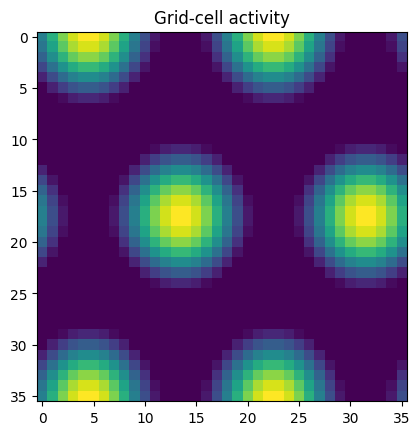

In [ ]:
#load grid-cell model
Ngc = 36 #smallest possible so far: 36
modelBF = newModel(N=Ngc, lambda_net=14, asymcutoff=5)
#load steady state (grid pattern)
modelBF.getSteadyState(tolerance=1e-15)
SteadyState = modelBF.s
plt.imshow(SteadyState)
#np.load('/Users/michi/Documents/2 Neuro/Praktikum KTH/Code/steadystate_128_14_0_default.npy')
plt.title('Grid-cell activity')


In [3]:
#create trajectory of grid-cell network
T = 50
dt = 0.001
nts = int(T/dt)
#input velocity
theta360 = np.linspace(0, 2*np.pi, nts)

#add noise:
noise = 1

#simulate
gc_traj = np.zeros([nts, Ngc, Ngc])

#get steady state
modelBF.s = SteadyState 
#modelBF.s = np.load('/Users/michi/Documents/2 Neuro/Praktikum KTH/Code/steadystate_128_14_0_default.npy')
noise_std = np.mean(modelBF.s) *0.1
for t in tqdm(range(nts), total=nts):
    gc_traj[t] = modelBF.s
    modelBF.switchKernal(v = 0.4, theta0= theta360[t])
    modelBF.updateSystem()
    #add noise
    modelBF.s += np.random.normal(0,noise_std, (Ngc, Ngc))
    
gc_traj_res = np.reshape(gc_traj, (nts, Ngc**2))

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:31<00:00, 1599.13it/s]


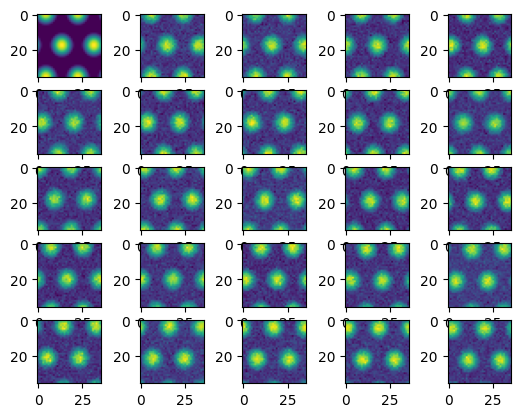

In [4]:
fig,ax=plt.subplots(5,5)
for i, axi in enumerate(ax.flat):
    
    axi.imshow(gc_traj[i*100,:,:])

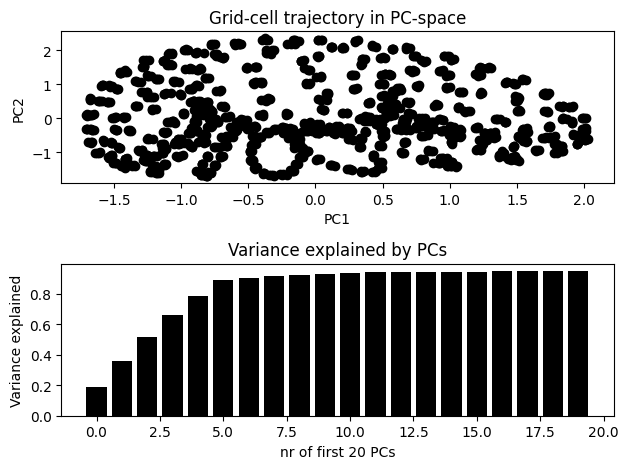

In [5]:
pca = PCA(whiten=True)
scores = pca.fit_transform(X=gc_traj_res.T)
fig, ax = plt.subplots(2)
ax[0].scatter(scores[:,0], scores[:,1],color='black')
ax[0].set_title('Grid-cell trajectory in PC-space')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

upto = 20
ax[1].set_xlabel('nr of first {} PCs'.format(upto))
ax[1].set_ylabel('Variance explained')
ax[1].bar(np.arange(upto),np.cumsum(pca.explained_variance_ratio_)[:upto],color='black')
ax[1].set_title('Variance explained by PCs')
plt.tight_layout()

# -> 1st three components explain almost 100% of variance

In [13]:

# Set the number of threads for PyTorch
torch.set_num_threads(2)

# Define a neural network block with residual connections
class DeepRitzBlock(nn.Module):
    def __init__(self, h_size):
        super(DeepRitzBlock, self).__init__()
        # Define a sequential block with two linear layers and Tanh activations
        self.block = nn.Sequential(
            nn.Linear(h_size, h_size),
            nn.Tanh(),
            nn.Linear(h_size, h_size),
            nn.Tanh()
        )

    def forward(self, x):
        # Apply the block and add the input (residual connection)
        return self.block(x) + x

# Define a neural network model using DeepRitzBlock
class NeuralNetwork(nn.Module):
    def __init__(self, in_size, h_size=10, block_size=1, dev="cpu"):
        super(NeuralNetwork, self).__init__()
        self.dev = dev
        self.dim_input = in_size
        self.dim_h = h_size
        self.num_blocks = block_size

        # Initialize the layers list with either a linear layer or padding
        layers = [nn.ConstantPad1d((0, self.dim_h - self.dim_input), 0) if self.dim_input <= self.dim_h else
                  nn.Linear(self.dim_input, self.dim_h)]

        # Append DeepRitzBlock instances to the layers list
        for _ in range(self.num_blocks):
            layers.append(DeepRitzBlock(self.dim_h))

        # Add a final linear layer to map back to the input size
        layers.append(nn.Linear(self.dim_h, self.dim_input))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the model
        return self.model(x)

def generate_surrogate(x):
    x_surrogate = []
    for i, x_i in enumerate(x):
        x_surrogate_ = []
        for l in range(len(x_i)):
            fft_original = np.fft.rfft(x_i[l])
            magnitude = np.abs(fft_original)
            random_phases = np.exp(1j * np.random.uniform(0, 2 * np.pi, len(fft_original)))
            fft_random = magnitude * random_phases
            random_signal = np.fft.irfft(fft_random)
            x_surrogate_.append(random_signal)
        x_surrogate.append(np.array(x_surrogate_))
    return x_surrogate
#function for epr estimation
def EPR_nn_est_params(data_, dt, epoch_max=3000, step_test=100, data_normalisation=True,
                      reverse_training=False, dim_h=10, num_blocks=2):
    data_ij = data_
    dim, length = data_ij.shape

    if reverse_training:
        xt = torch.Tensor(data_ij[:, length // 2:].T)
        xt_test = torch.Tensor(data_ij[:, :length // 2].T)
    else:
        xt = torch.Tensor(data_ij[:, :length // 2].T)
        xt_test = torch.Tensor(data_ij[:, length // 2:].T)

    dim_x = dim
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    force_network = NeuralNetwork(dim_x, dim_h, num_blocks, dev).to(dev)

    data = xt - torch.mean(xt, dim=0)
    if data_normalisation:
        data /= torch.std(data, dim=0)

    data_mid = 0.5 * (data[1:, :] + data[:-1, :])
    xdiff = data[1:, :] - data[:-1, :]

    optimizer = torch.optim.Adadelta(force_network.parameters(), lr=1e-2)

    All_loss_train = []
    print('training')
    for epoch in tqdm(range(epoch_max), total=epoch_max):
        force_network.train()
        optimizer.zero_grad()
        dxmid = force_network(data_mid)
        jj = torch.sum(dxmid * xdiff, dim=1)
        loss = -2 * torch.mean(jj) ** 2 / (dt * torch.var(jj))
        loss.backward()
        optimizer.step()

        if epoch % step_test == 0:
            torch.save(force_network.state_dict(), f'saved_params/force_network_params_epoch_{epoch}.pt')
            All_loss_train.append(-loss.item())

    saved_params_dir = 'saved_params'
    steps = tqdm(range(0, epoch_max, step_test), total=epoch_max/step_test)
    test_losses = []

    data_test = xt_test - torch.mean(xt_test, dim=0)
    if data_normalisation:
        data_test /= torch.std(data_test, dim=0)

    data_mid_test = 0.5 * (data_test[1:, :] + data_test[:-1, :])
    xdiff_test = data_test[1:, :] - data_test[:-1, :]

    print('testing')
    for step in steps:
        param_file = os.path.join(saved_params_dir, f'force_network_params_epoch_{step}.pt')
        if os.path.exists(param_file):
            force_network.load_state_dict(torch.load(param_file))
            force_network.eval()
            with torch.no_grad():
                dxmid_test = force_network(data_mid_test)
                jj_test = torch.sum(dxmid_test * xdiff_test, dim=1)
                loss_test = -2 * torch.mean(jj_test) ** 2 / (dt * torch.var(jj_test))
                test_losses.append(-loss_test.item())
        else:
            test_losses.append(None)

    epr_train, epr_test = np.max(All_loss_train), np.max(test_losses)
    print(f"Maximum EPR on training data: {epr_train}")
    print(f"Maximum EPR on test data: {epr_test}")

    return test_losses, All_loss_train



array([10, 10, 10, 10, 10])

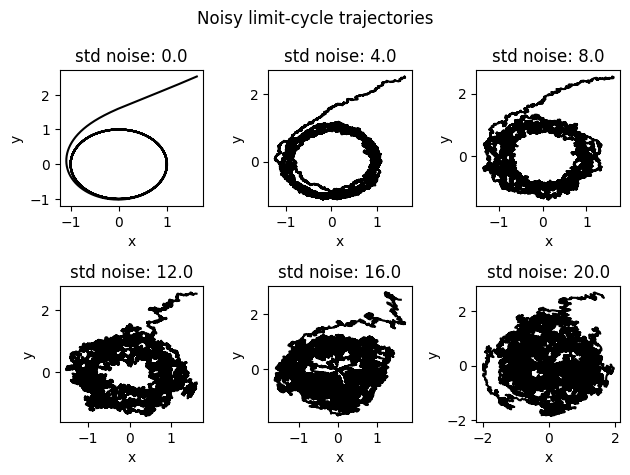

In [4]:
#create input trajectories from different stochastic processes
#define seed for reproducibility
np.random.seed(25)
state = np.random.get_state()
np.random.set_state(state)
#true random-walk
def rn_walk(x0 = None, ndim = 2, T = 50, dt= 0.001, noise_std = 0.1, bias = 0, low_bound=None, up_bound=None):
    nts = int(T/dt)
    
    x = np.zeros([ndim, nts])

    if x0 != None:
        x[:, 0] = x0
    #boundaries = (xmin, xmax, ymin, ymax)
    #if (low_bound.size != ndim) or (up_bound.size != ndim):
     #   print('dimensions of system and boundary dimensions dont match')

    noise = np.random.normal(bias, noise_std, (ndim, nts))
    for ts in range(nts-1):
        x[:, ts+1] = x[:, ts] + noise[:, ts] * dt

        #reset positions out of boundaries
        
        if type(low_bound) != type(None):
            x[:, ts+1] = np.where( (x[:, ts+1]<low_bound), up_bound - (low_bound-x[:, ts+1]), x[:, ts+1])
        if type(up_bound) != type(None):
            x[:, ts+1] = np.where( (x[:, ts+1]>up_bound), low_bound + (x[:,ts+1]-up_bound), x[:, ts+1])
    

    return x
#polar random-walk (looks yet a bit biased)
def polar_rn_walk(r0 = 1, theta0 = 1, T = 50, dt= 0.001, noise_std = 0.1):
    nts = int(T/dt)
    r, theta = np.zeros([nts]), np.zeros([nts])

    r[0], theta[0] = r0, theta0
    noise = np.random.normal(0, noise_std, (2, nts))
    for ts in range(nts-1):
        dr = noise[0,ts] * dt
        r[ts+1] = r[ts] + dr
        if r[ts+1] < 0:
            r[ts+1] = 0

        dtheta = noise[1,ts] * dt
        theta[ts+1] = theta[ts] + dtheta
    #calculate x and y cooridnates from polar ones
    x = np.cos(theta) * r
    y = np.sin(theta) * r
    return x, y
#noisy limit cycle
def noisy_limcycle(r0 = 1, theta0 = 1, T = 50, dt= 0.001, w = 1, noise_std = 0.1):
    nts = int(T/dt)
    r, theta = np.zeros([nts]), np.zeros([nts])

    r[0], theta[0] = r0, theta0
    noise = np.random.normal(0, noise_std, (2, nts))
    for ts in range(nts-1):
        drdt = r[ts] * (1 - r[ts])
        r[ts+1] = r[ts] + (drdt + noise[0,ts]) * dt
        if r[ts+1] < 0:
            r[ts+1] = 0

        dthetadt = w 
        theta[ts+1] = theta[ts] + (dthetadt + noise[1,ts]) * dt
    #calculate x and y cooridnates from polar ones
    x = np.cos(theta) * r
    y = np.sin(theta) * r
    return x, y

# x, y = noisy_limcycle(r0 = 5, noise_std=5)
# plt.plot(x,y)
fig, ax = plt.subplots(2,3)
nstds = np.linspace(0,20,6)
for i, axi in enumerate(ax.flat):
    x, y = noisy_limcycle( r0=3, theta0=1, noise_std= nstds[i])
    axi.plot(x,y, color='black')
    axi.set_title('std noise: {}'.format(nstds[i]))
    axi.set_xlabel('x')
    axi.set_ylabel('y')
plt.suptitle('Noisy limit-cycle trajectories')
plt.tight_layout()

#create one for epr measurement
T = 50
dt = 0.001
limcyc_traj = np.zeros([2, int(T/dt)])
limcyc_traj[0], limcyc_traj[1] = noisy_limcycle(T = T, dt = dt, noise_std = 10)

Rn_walk_polar = np.zeros([2, int(T/dt)])
Rn_walk_polar[0], Rn_walk_polar[1] = polar_rn_walk(T = T, dt = dt, noise_std = 10)

Rn_walk = rn_walk(T = T, dt = dt, ndim=2, noise_std=20)#, low_bound= np.array([-1,-1]), up_bound=np.array([1,1]))



In [5]:
# Test with random timeseries of dimension N timelength T

# Generate random time series data
time_series = Rn_walk#scores[:,:3].T#(itmaps[-1] - np.mean(itmaps[-1], 1)[:, np.newaxis])/np.std(itmaps[-1], 1)[:, np.newaxis] #np.random.randn(N, T)

# Change the current working directory: IN WHICH YOU HAVE A FOLDER NAMED "saved_params"
cd = '/Users/michi/Documents/2 Neuro/Praktikum KTH/Code'
os.chdir(cd) #Users/pascal.helson/Documents/PYTHON/testing_code')#

# Verify the change
print("Current Working Directory:", os.getcwd())

# Setting parameters
working_params=True
epoch_max, step_test, dim_h, num_blocks = 20000, 100, 5, 1
if working_params ==True:
    epoch_max, step_test, dim_h, num_blocks = 100, 10, 5, 1 #working params

test_losses, All_loss_train = EPR_nn_est_params(time_series, dt=0.001,
                    epoch_max=epoch_max, step_test=step_test, reverse_training=False, data_normalisation=True, dim_h=dim_h, num_blocks=num_blocks)

sigma_test = test_losses
sigma_train = All_loss_train
test_array = np.arange(0, epoch_max, 1)



Current Working Directory: c:\Users\michi\Documents\2 Neuro\Praktikum KTH\Code
training


100%|██████████| 100/100 [00:01<00:00, 71.79it/s]
 20%|██        | 2/10.0 [00:00<00:00, 17.33it/s]

testing


100%|██████████| 10/10.0 [00:00<00:00, 20.67it/s]

Maximum EPR on training data: 0.006213697604835033
Maximum EPR on test data: 0.00025905080838128924


In [10]:
#save results:
results = {'trajectory':time_series, 'EPR_train':sigma_train, 'EPR_test':sigma_test}

file_name = 'gc_N36_lamd14_3PC_vel0_norm__epochmax{}_steptest{}_dimh{}_numblocks{}'.format(epoch_max, step_test, dim_h, num_blocks)
path = '/saved_results/'
subpath = 'grid-cell models/'
if subpath !=None:
    path = path + subpath


np.save(cd + path + file_name, results)

(2, 25000)

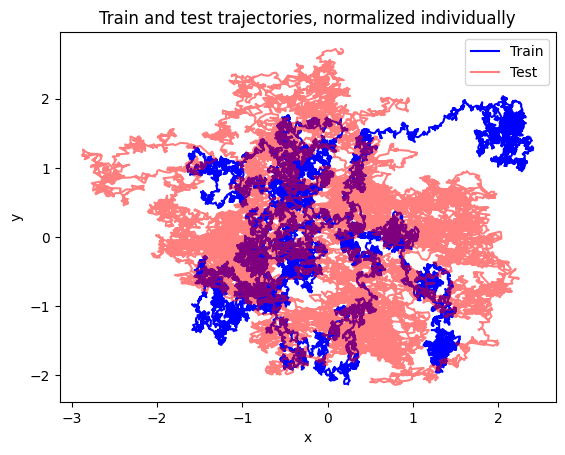

In [11]:
ntp = Rn_walk.shape[1]
Rn_walk_train = Rn_walk[:,:ntp//2]
Rn_walk_test = Rn_walk[:,ntp//2:]

Rn_train_norm = (Rn_walk_train-np.mean(Rn_walk_train, 1)[:, np.newaxis])/np.std(Rn_walk_train, 1)[:, np.newaxis]
Rn_test_norm = (Rn_walk_test-np.mean(Rn_walk_test, 1)[:, np.newaxis])/np.std(Rn_walk_test, 1)[:, np.newaxis]

plt.plot(Rn_train_norm[0], Rn_train_norm[1], color='blue',label='Train')
plt.plot(Rn_test_norm[0], Rn_test_norm[1], color='red',alpha=0.5,label='Test')
plt.title('Train and test trajectories, normalized individually')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
Rn_train_norm.shape


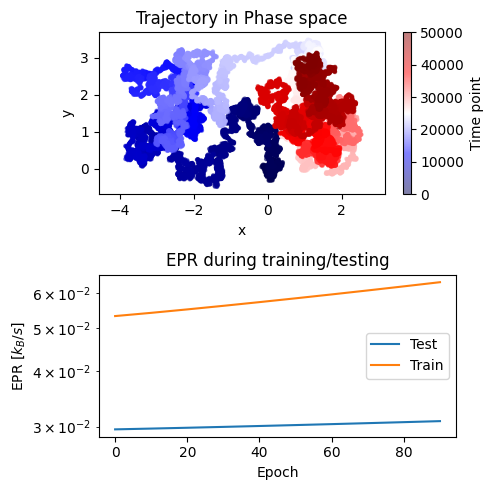

In [12]:
#plot results
fig, ax = plt.subplots(2,1,figsize=(5,5))

#create colormap to color-code time of trajectory
ntp = time_series.shape[1]
cmap = plt.cm.seismic
norm = plt.Normalize(vmin=0, vmax=ntp)
sc = ax[0].scatter(
    time_series[0, :],
    time_series[1, :],
    alpha = 0.5,
    c=np.arange(ntp),        # color each point by time index
    cmap=cmap,
    norm=norm,
    s=5                   
)
plt.colorbar(sc, ax=ax[0], label="Time point")
ax[0].set_title('Trajectory in Phase space')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

ax[1].plot(test_array[::step_test],sigma_test, label = 'Test')
ax[1].grid(axis ='y')
train_array = np.arange(0,epoch_max,1)
ax[1].plot(train_array[::step_test], sigma_train[::1], label = 'Train')
ax[1].set_yscale('log')
ax[1].set_title('EPR during training/testing')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('EPR ['r'$k_B/s$'']')
#ax[1].set_title
ax[1].legend()
#plt.suptitle("Entropy production rate of trajectory")
plt.tight_layout()
plt.show()
#how interpret plot?

In [16]:
#load 3 state markov chains

all_mc = np.load(cd + '/saved_results/ mc(pr,t)p-range(0.1,0.9,10).npy')
#c:/Users/michi/Documents/2 Neuro/Praktikum KTH/Code/saved_results/ mc(pr,sim,t)p-range(0,1,10)'
#concatenate every second trial for longer trajectories
#all_mc = np.reshape(all_mc, (20, 5, 2*50000))#np.hstack((all_mc[:,:5], all_mc[:,5:]))
def mc_to_matrix(mc, n_states=3):
    """
    Convert a Markov chain sequence into a one-hot state matrix.

    Parameters
    ----------
    mc : array-like of shape (T,)
        Sequence of states (integers 0..n_states-1).
    n_states : int
        Number of possible states.

    Returns
    -------
    mat : ndarray of shape (n_states, T)
        One-hot encoded state matrix.
    """
    mc = np.asarray(mc)
    T = mc.shape[0]
    mat = np.zeros((n_states, T), dtype=int)
    mat[mc, np.arange(T)] = 1
    return mat

#test one trajectory:
ps = np.linspace(0.1,0.9,10)
pi= 9
print('Pr state-up:',ps[pi])
time_series = all_mc[pi]#mc_to_matrix(all_mc[pi])#[pi,0:2,::5] 
epoch_max, step_test, dim_h, num_blocks = 300, 100, 3, 2
test_losses, All_loss_train = EPR_nn_est_params(time_series, dt=0.01,
                        epoch_max=epoch_max, step_test=step_test, reverse_training=False, data_normalisation=True, dim_h=dim_h, num_blocks=num_blocks)
test_array = np.arange(0, epoch_max, 1)
train_array = np.arange(0, epoch_max, 1)

Pr state-up: 0.9
training


100%|██████████| 300/300 [00:03<00:00, 98.86it/s] 
100%|██████████| 3/3.0 [00:00<00:00, 28.79it/s]

testing
Maximum EPR on training data: 0.013692893087863922
Maximum EPR on test data: 0.0038322200998663902


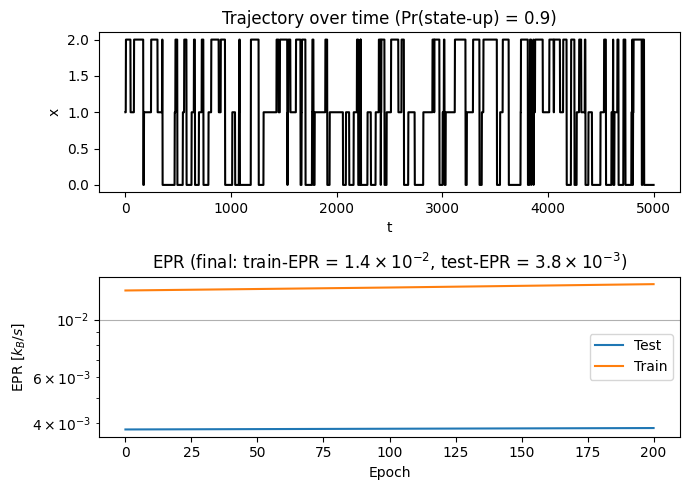

In [17]:
#plot results
fig, ax = plt.subplots(2,1,figsize=(7,5))

ax[0].plot(time_series[0,:time_series.shape[1]//4], color='black')
ax[0].set_title('Trajectory over time (Pr(state-up) = {})'.format(round(ps[pi],2)))
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')

def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """Return number in scientific notation as LaTeX string."""
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is not None:
        coeff = f"{coeff:.{precision}f}"
    return r"${} \times 10^{{{}}}$".format(coeff, exponent)

test_array = np.arange(0, epoch_max, 1)
ax[1].grid(axis ='y')
ax[1].plot(test_array[::step_test],test_losses, label = 'Test')
train_array = np.arange(0,epoch_max,1)
ax[1].plot(train_array[::step_test], All_loss_train[::1], label = 'Train')
ax[1].set_yscale('log')
#plt.axhline(epr, color = 'r')
ax[1].set_title('EPR (final: train-EPR = {}, test-EPR = {})'.format(sci_notation(All_loss_train[-1]), sci_notation(test_losses[-1])))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('EPR ['r'$k_B/s$'']')
#ax[1].set_title
ax[1].legend()
#plt.suptitle("Entropy production rate of trajectory")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Entropy production rate of 2d 3-state Markov process\nusing different up-state probabilities p')

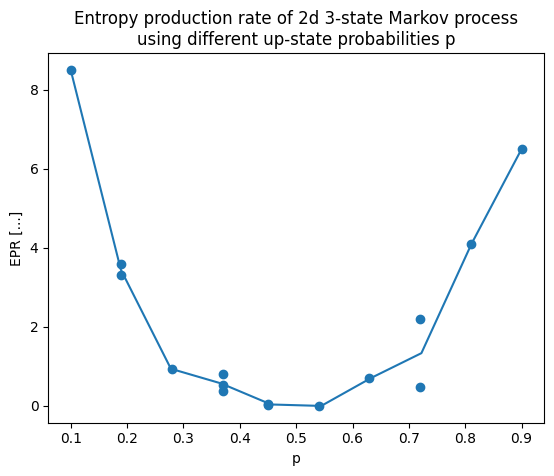

In [194]:
eprs = [8.5, (3.6+3.3)/2, 0.94, (0.39+0.52+0.8)/3, (0.055+0.018)/2,0, 0.71,(2.2+0.47)/2, 4.1, 6.5]
eprs_scat = [8.5, 3.6, 3.3, 0.94, 0.39, 0.52, 0.8, 0.055, 0.018, 0, 0.71, 2.2, 0.47, 4.1,6.5]
eprs_ps = [0.1, 0.19, 0.19, 0.28, 0.37, 0.37, 0.37, 0.45, 0.45, 0.54, 0.63, 0.72, 0.72, 0.81, 0.9]
plt.plot(ps,eprs)
plt.scatter(eprs_ps,eprs_scat)
plt.xlabel('p')
plt.ylabel('EPR [...]')
plt.title('Entropy production rate of 2d 3-state Markov process\nusing different up-state probabilities p')

In [29]:
final_epr = []
final_epr_train = []

10
prob: 0.9 sim: 0
0 9 / 10
training


100%|██████████| 20000/20000 [02:56<00:00, 113.10it/s]
  1%|          | 2/200.0 [00:00<00:13, 14.99it/s]

testing


100%|██████████| 200/200.0 [00:07<00:00, 28.44it/s]


Maximum EPR on training data: 7.642279148101807
Maximum EPR on test data: 5.855978012084961


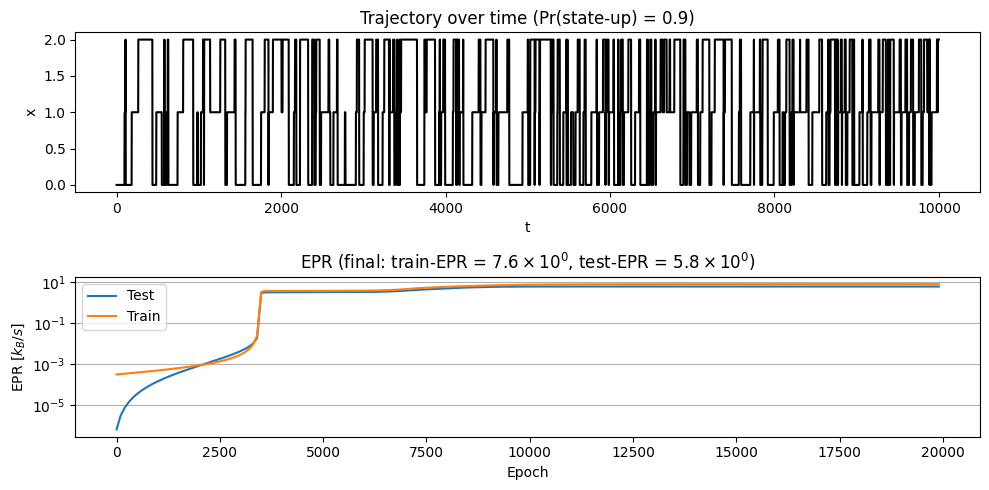

prob: 0.9 sim: 1
1 9 / 10
training


100%|██████████| 20000/20000 [03:07<00:00, 106.78it/s]
  2%|▏         | 3/200.0 [00:00<00:08, 23.76it/s]

testing


100%|██████████| 200/200.0 [00:07<00:00, 27.94it/s]


Maximum EPR on training data: 7.351280689239502
Maximum EPR on test data: 5.960351467132568


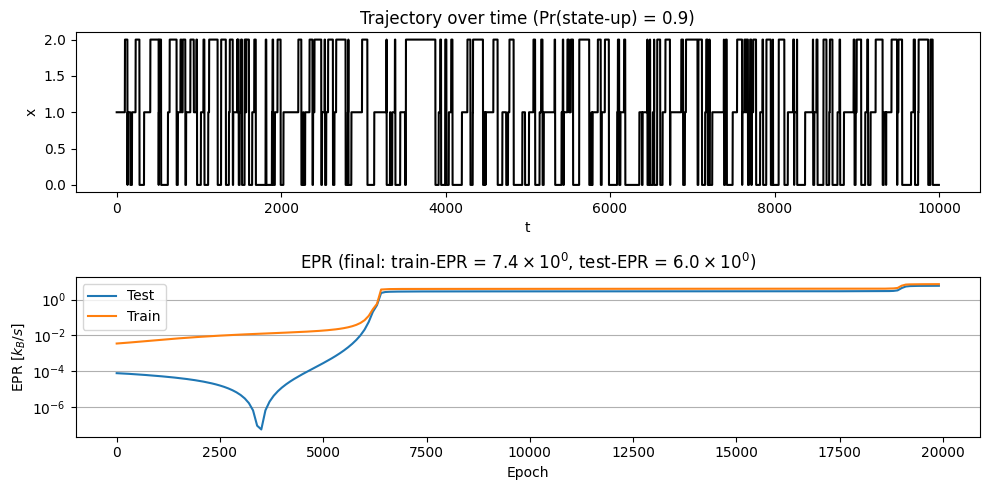

prob: 0.9 sim: 2
2 9 / 10
training


100%|██████████| 20000/20000 [03:23<00:00, 98.36it/s] 
  2%|▏         | 3/200.0 [00:00<00:08, 23.92it/s]

testing


100%|██████████| 200/200.0 [00:07<00:00, 26.87it/s]


Maximum EPR on training data: 7.369536399841309
Maximum EPR on test data: 6.701354503631592


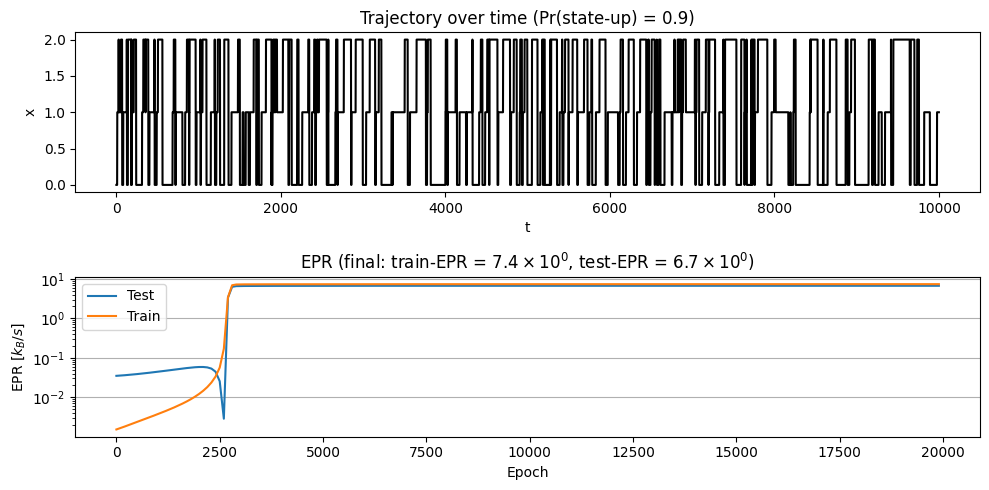

prob: 0.9 sim: 3
3 9 / 10
training


100%|██████████| 20000/20000 [03:01<00:00, 110.17it/s]
  2%|▏         | 3/200.0 [00:00<00:07, 25.65it/s]

testing


100%|██████████| 200/200.0 [00:06<00:00, 30.29it/s]


Maximum EPR on training data: 3.770127296447754
Maximum EPR on test data: 3.5547163486480713


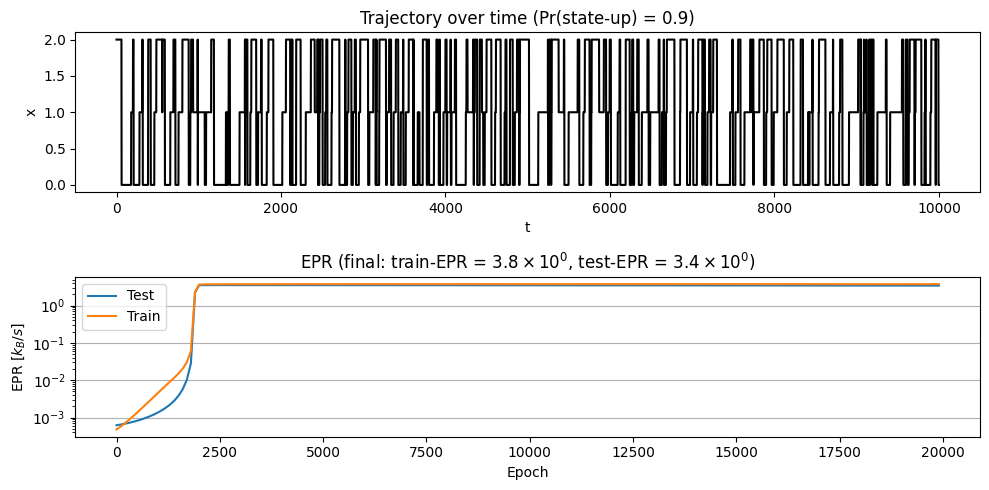

prob: 0.9 sim: 4
4 9 / 10
training


100%|██████████| 20000/20000 [03:02<00:00, 109.83it/s]
  2%|▏         | 4/200.0 [00:00<00:06, 31.32it/s]

testing


100%|██████████| 200/200.0 [00:06<00:00, 29.93it/s]


Maximum EPR on training data: 7.721408843994141
Maximum EPR on test data: 6.454044818878174


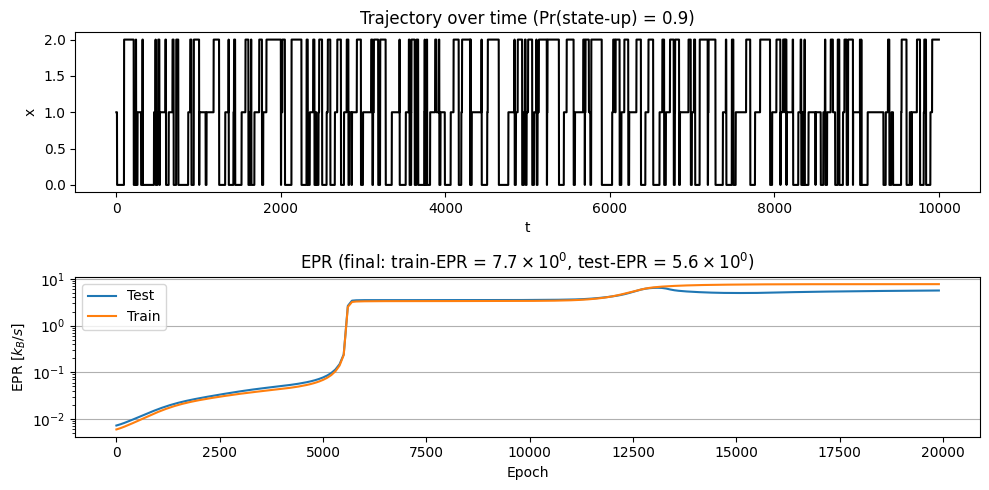

prob: 0.9 sim: 5
5 9 / 10
training


100%|██████████| 20000/20000 [03:07<00:00, 106.68it/s]
  2%|▏         | 3/200.0 [00:00<00:07, 27.44it/s]

testing


100%|██████████| 200/200.0 [00:06<00:00, 29.04it/s]


Maximum EPR on training data: 3.8700737953186035
Maximum EPR on test data: 3.099644660949707


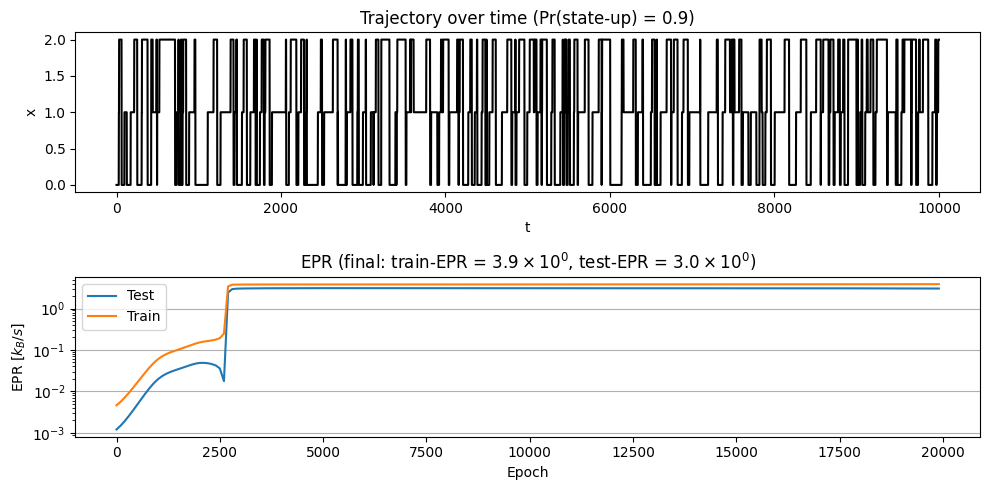

prob: 0.9 sim: 6
6 9 / 10
training


100%|██████████| 20000/20000 [03:05<00:00, 107.71it/s]
  2%|▏         | 3/200.0 [00:00<00:06, 29.83it/s]

testing


100%|██████████| 200/200.0 [00:06<00:00, 29.76it/s]


Maximum EPR on training data: 7.675579071044922
Maximum EPR on test data: 6.164219379425049


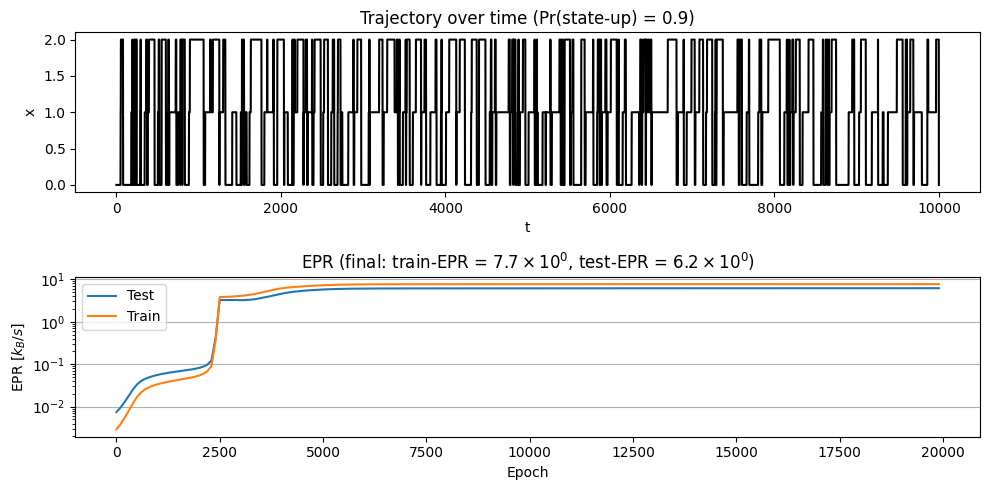

prob: 0.9 sim: 7
7 9 / 10
training


100%|██████████| 20000/20000 [03:29<00:00, 95.63it/s] 
  2%|▏         | 3/200.0 [00:00<00:07, 26.44it/s]

testing


100%|██████████| 200/200.0 [00:07<00:00, 27.63it/s]


Maximum EPR on training data: 7.613130569458008
Maximum EPR on test data: 6.624571323394775


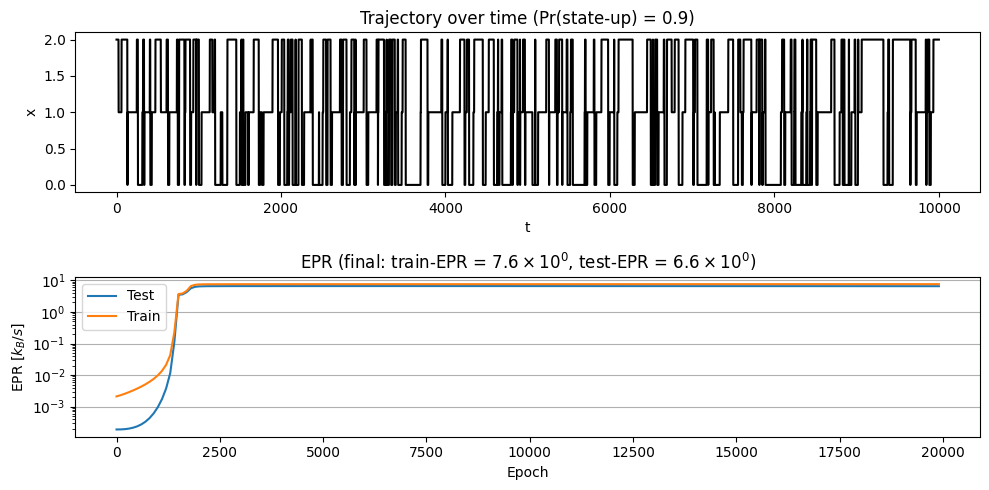

prob: 0.9 sim: 8
8 9 / 10
training


100%|██████████| 20000/20000 [03:34<00:00, 93.21it/s] 
  1%|          | 2/200.0 [00:00<00:10, 18.22it/s]

testing


100%|██████████| 200/200.0 [00:07<00:00, 27.69it/s]


Maximum EPR on training data: 6.72052001953125
Maximum EPR on test data: 7.45311164855957


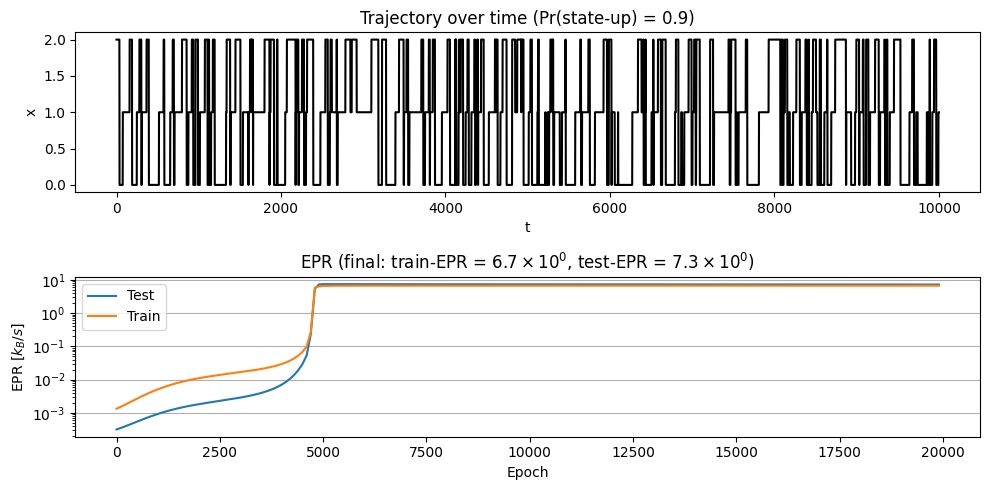

prob: 0.9 sim: 9
9 9 / 10
training


100%|██████████| 20000/20000 [03:34<00:00, 93.40it/s] 
  2%|▏         | 3/200.0 [00:00<00:08, 24.09it/s]

testing


100%|██████████| 200/200.0 [00:07<00:00, 27.97it/s]


Maximum EPR on training data: 7.398930549621582
Maximum EPR on test data: 7.99536657333374


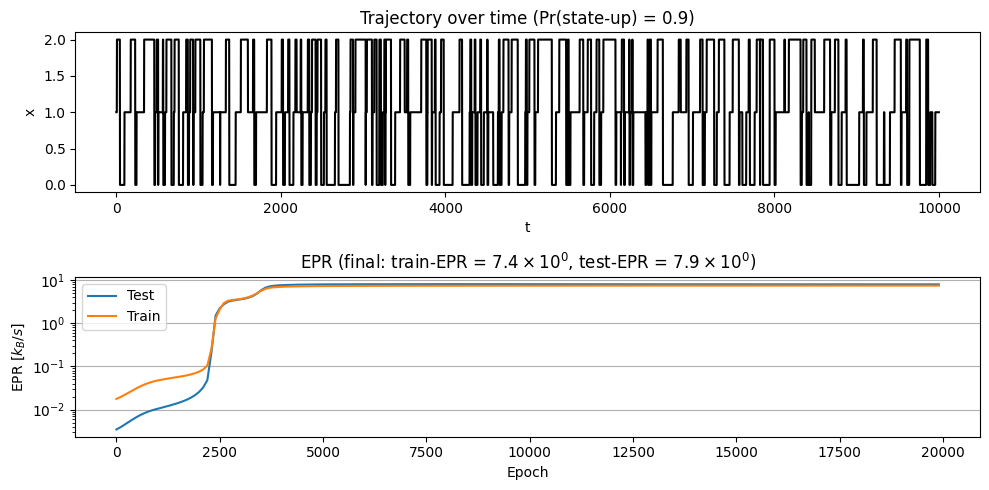

In [30]:
#simulate epr vs p for 3 state model
all_mc = np.load(cd + '/saved_results/ mc(pr,sim,t)p-range(0.1,0.9,10).npy')
#estimate epr

# Setting parameters
working_params=False
epoch_max, step_test, dim_h, num_blocks = 20000, 100, 3, 2
npr, nsim, ntp = all_mc.shape
nsim = nsim//2
if working_params ==True:
    epoch_max, step_test, dim_h, num_blocks = 1000, 10, 3, 2 #working params
    npr, nsim, ntp = all_mc.shape
    nsim = nsim//2

pi = 9
print(nsim)
for i in range(nsim):
    print('prob:', ps[pi], 'sim:',i)
    sim = 2*i
    print(i, pi,'/', npr)
    time_series = all_mc[pi, sim:sim+2]#[np.newaxis,:]
    test_losses, All_loss_train = EPR_nn_est_params(time_series, dt=0.01,
                        epoch_max=epoch_max, step_test=step_test, reverse_training=False, data_normalisation=True, dim_h=dim_h, num_blocks=num_blocks)
    final_epr.append(test_losses[-1])
    final_epr_train.append(All_loss_train[-1])

    fig, ax = plt.subplots(2,1,figsize=(10,5))

    ax[0].plot(time_series[0,:time_series.shape[1]//2], color='black')
    ax[0].set_title('Trajectory over time (Pr(state-up) = {})'.format(round(ps[pi],2)))
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')

    test_array = np.arange(0, epoch_max, 1)
    ax[1].grid(axis ='y')
    ax[1].plot(test_array[::step_test],test_losses, label = 'Test')
    train_array = np.arange(0,epoch_max,1)
    ax[1].plot(train_array[::step_test], All_loss_train[::1], label = 'Train')
    ax[1].set_yscale('log')
    #plt.axhline(epr, color = 'r')
    ax[1].set_title('EPR (final: train-EPR = {}, test-EPR = {})'.format(sci_notation(All_loss_train[-1]), sci_notation(test_losses[-1])))
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('EPR ['r'$k_B/s$'']')
    #ax[1].set_title
    ax[1].legend()
    #plt.suptitle("Entropy production rate of trajectory")
    plt.tight_layout()
    plt.show()
    

In [207]:
final_epr_copy = final_epr.copy()
train_eprs = np.array([3.9358, 7.8098, 7.2726, 2.7899, 3.0358, 3.3160, 4.6573, 5.6536, 4.6471, 6.3892])

In [31]:
final_epr_train

[7.642279148101807,
 7.351280689239502,
 7.369536399841309,
 3.770127296447754,
 7.721408843994141,
 3.8700737953186035,
 7.675579071044922,
 7.613130569458008,
 6.72052001953125,
 7.398930549621582]

In [33]:
all_mc = np.save(cd + '/saved_results/final_epr_p0.9_nsim10_test2_iInvalid', final_epr)


Text(0.5, 1.0, 'EPR estimates of 2d 3-state mc')

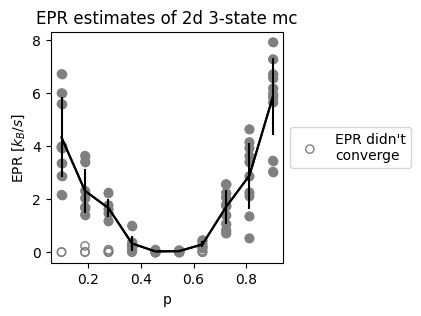

In [45]:
#load and plot
samps1 = np.load(cd + '/saved_results/final_epr_p0.1_nsim10_test2_iInvalid17.npy')
samps19 = np.load(cd + '/saved_results/final_epr_p0.19_nsim10_test2_iInvalid247.npy')
samps29 = np.load(cd + '/saved_results/final_epr_p0.29_nsim10_test2_iInvalid03569.npy')
samps38 = np.load(cd + '/saved_results/final_epr_p0.38_nsim10_test2_iInvalid08.npy')
samps46 = np.load(cd + '/saved_results/final_epr_p0.46_nsim10_test2_iInvalid78.npy')
samps54 = np.load(cd + '/saved_results/final_epr_p0.54_nsim10_test2_iInvalid0128.npy')
samps63 = np.load(cd + '/saved_results/final_epr_p0.63_nsim10_test2_iInvalid0134.npy')
samps72 = np.load(cd + '/saved_results/final_epr_p0.72_nsim10_test2_iInvalid.npy')
samps81 = np.load(cd + '/saved_results/final_epr_p0.81_nsim10_test2_iInvalid.npy')
samps9 = np.load(cd + '/saved_results/final_epr_p0.9_nsim10_test2_iInvalid.npy')

all_samps = [samps1, samps19, samps29, samps38, samps46, samps54, samps63, samps72, samps81, samps9]

all_samps_valid = [samps1[[0,2,3,4,5,6,8,9]], 
             samps19[[0,1,3,5,6,8,9]], 
             samps29[[1,2,4,7,8]], 
             samps38[[1,2,3,4,5,6,7,9]], 
             samps46[[0,1,2,3,4,5,6,9]], 
             samps54[[3,4,5,6,7,9]], 
             samps63[[2,5,6,7,8,9]], 
             samps72, samps81, samps9]

plt.figure(figsize=(3,3))
ps = np.linspace(0.1,0.9,10)
means_valid = []
stds_valid = []
for pi in range(ps.size):

    valid_samps_arr = np.array(all_samps_valid[pi])
    samps = all_samps[pi]
    plt.scatter(np.repeat(ps[pi], len(samps)), samps, facecolors='none', edgecolors='grey')
    plt.scatter(np.repeat(ps[pi], len(valid_samps_arr)), valid_samps_arr, color = 'grey')

    
    means_valid.append(valid_samps_arr.mean())
    stds_valid.append(valid_samps_arr.std())
plt.scatter(ps[0], all_samps[0][0],facecolors='none', edgecolors='grey' , label = "EPR didn't\nconverge")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot(ps, means_valid, color='black')
plt.errorbar(ps, means_valid, yerr = stds_valid, color = 'black')

plt.xlabel('p')
plt.ylabel('EPR ['r'$k_B/s$'']')
plt.title('EPR estimates of 2d 3-state mc')